In [42]:
import os, sys, time

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable, Function

import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import pylab
import matplotlib.pyplot as plt

from scipy.misc import imread

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import loadseg
import expdir
import intersect
import upsample
from labelprobe import cached_memmap

In [67]:
gpu = 0

cuda = True if gpu is not None else False
use_mult_gpu = isinstance(gpu, list)
if cuda:
    if use_mult_gpu:
        os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu).strip('[').strip(']')
    else:
        os.environ['CUDA_VISIBLE_DEVICES'] = '%d' % gpu
print(torch.cuda.device_count(), use_mult_gpu, cuda)

(1L, False, True)


In [3]:

directory='/home/ruthfong/NetDissect/probes/pytorch_alexnet_imagenet'
if not os.path.exists(directory):
    directory='/scratch/local/ssd/ruthfong/NetDissect/probes/pytorch_alexnet_imagenet'
    assert(os.path.exists(directory))
blob='features'

In [4]:
ed = expdir.ExperimentDirectory(directory)

In [5]:
info = ed.load_info()
blob_info = ed.load_info(blob=blob)
shape = blob_info.shape
ds = loadseg.SegmentationData(info.dataset)
categories = ds.category_names()

In [6]:
K = shape[1]
L = ds.label_size()
N = ds.size()

In [47]:
quantile = 0.005
qcode = ('%f' % quantile).replace('0.','').rstrip('0')
quantdata = ed.open_mmap(blob=blob, part='quant-*', shape=(K, -1))
threshold = quantdata[:, int(round(quantdata.shape[1] * quantile))]
thresh = threshold[:, np.newaxis, np.newaxis]

In [51]:
fnread = ed.mmap_filename(blob=blob)
blobdata = cached_memmap(fnread, mode='r', dtype='float32', shape=shape)

In [7]:
#from labelprobe import onehot, primary_categories_per_index, cached_memmap

In [8]:
from indexdata import load_image_to_label

In [9]:
image_to_label = load_image_to_label(directory)

In [64]:
linear_ind_ious = ed.open_mmap(blob=blob, part='linear_ind_ious', mode='r', dtype='float32', shape=(L,N))
#single_ind_ious = ed.open_mmap(blob=blob, part='single_ind_ious', mode='r', dtype='float32', shape=(L,N,K))
linear_set_ious = ed.open_mmap(blob=blob, part='linear_set_ious', mode='r', dtype='float32', shape=(L,))
#single_set_ious = ed.open_mmap(blob=blob, part='single_set_ious', mode='r', dtype='float32', shape=(L,K))
weights = ed.open_mmap(blob=blob, part='linear_weights', mode='r', dtype='float32', shape=(L,K))

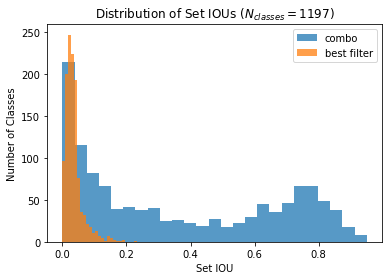

In [21]:
best_set_ious = np.max(single_set_ious[1:], axis=1)
f, ax = plt.subplots(1,1)
ax.hist(linear_set_ious[1:], alpha=0.75, bins=25, label='combo')
ax.hist(best_set_ious, alpha=0.75, bins=25, label='best filter')
ax.set_xlabel('Set IOU')
ax.set_ylabel('Number of Classes')
ax.set_title(r'Distribution of Set IOUs ($N_{classes}=%d$)' % (L-1))
ax.legend()
plt.show()

In [30]:
set_iou_rel = np.true_divide(linear_set_ious[1:], best_set_ious+1e-20)

1197


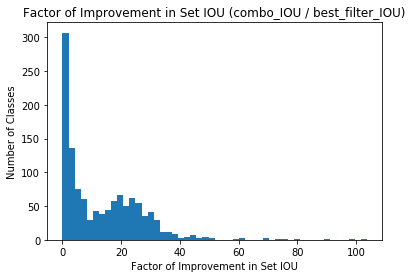

In [31]:
f, ax = plt.subplots(1,1)
ax.hist(set_iou_rel, bins=50)
ax.set_xlabel('Factor of Improvement in Set IOU')
ax.set_ylabel('Number of Classes')
ax.set_title('Factor of Improvement in Set IOU (combo_IOU / best_filter_IOU)')
#ax.legend()
plt.show()

In [32]:
thresh = 0.04
print np.sum(best_set_ious > thresh), np.sum(linear_set_ious[1:] > thresh)

358 977


In [33]:
# similar to their metric, except doesn't eliminate duplicate concepts
print np.sum(np.max(single_set_ious, axis=0) > thresh)

175


In [34]:
from viewprobe import NetworkProbe

In [35]:
net_probe = NetworkProbe(directory, blobs=[blob])

In [59]:
label_i = 19 # person
label_idx = np.where(image_to_label[:,label_i][0])
best_filter = np.argmax(single_set_ious[label_i])
best_img = np.argmax(single_ind_ious[label_i,:,best_filter])

In [62]:
print single_ind_ious[label_i,best_img,best_filter]

0.528105


In [68]:
best_imgs_idx = np.argsort(linear_ind_ious[label_i,:])[::-1]

In [65]:
from linearprobe_pytorch import CustomLayer

In [69]:
model = CustomLayer(K, upsample=True, up_size=(113, 113), act=True, positive=False)
model.weight.data[...] = torch.Tensor(weights[label_i])
if cuda:
    model.cuda()
model.eval()

CustomLayer (
  (upsample): Upsample(size=(113, 113), mode=bilinear)
  (activation): Sigmoid ()
)

In [181]:
img_i = best_imgs_idx[9]

In [182]:
input = torch.Tensor((blobdata[img_i] > thresh).astype(float)).unsqueeze(0)
input_var = Variable(input.cuda(), volatile=True) if cuda else Variable(input, volatile=True)

In [183]:
output_var = model(input_var)

In [184]:
soft_mask = output_var.data.cpu().numpy()
mask = (soft_mask > 0.5).astype(float)

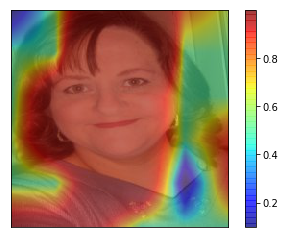

In [187]:
f, ax = plt.subplots(1,1)
img = imread(ds.filename(img_i))
#ax.imshow(imresize(img, size=soft_mask.shape, interp='bilinear'))
#cax = ax.imshow(soft_mask, alpha=0.5, cmap='jet')
ax.imshow(img)
cax = ax.imshow(imresize(soft_mask, size=img.shape[:2], interp='bilinear', mode='F'), alpha=0.5, cmap='jet')
f.colorbar(cax)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [ ]:
input = torch.Tensor((blobdata[img_i] > thresh).astype(float)).unsqueeze(0)
input_var = Variable(input.cuda(), volatile=True) if cuda else Variable(input, volatile=True)

In [53]:
def activation_visualization_single(filter_i, img_i):
    img = im

(63305, 256, 6, 6)

In [61]:
np.where(blobdata > thresh)

(array([    0,     0,     0, ..., 63304, 63304, 63304]),
 array([  4,   4,   4, ..., 254, 254, 254]),
 array([1, 2, 4, ..., 0, 1, 1]),
 array([5, 5, 0, ..., 2, 1, 2]))

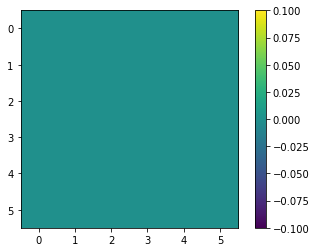

In [58]:
f, ax = plt.subplots(1,1)
img = imread(ds.filename(best_img))
mask = (blobdata[best_img][best_filter] > thresh[best_filter]).astype(float)
cax = ax.imshow(mask)
f.colorbar(cax)
plt.show()

In [40]:
sys.path.append('../../net_concepts/src')

In [41]:
from learn_concept_masks import *

In [42]:
label_cat = categories[np.where(labelcat[label_i])[0][0]]
print label_cat

object


In [43]:
fieldmap = blob_info.fieldmap

In [209]:
pf = loadseg.SegmentationPrefetcher(ds, categories=['texture'], once=True, batch_size=128, 
                                    ahead=4, thread=False)

In [210]:
batch = pf.fetch_batch()

In [213]:
x = [rec for rec in batch if rec['texture'] != []]

In [216]:
23x[0]['texture'])

list

In [45]:
perc_label = np.zeros(len(idx))

In [46]:
i = 0
for batch in pf.batches():
    for rec in batch:
        sw, sh = [rec[k] for k in ['sw', 'sh']]
        perc_label[i] = np.sum(rec[label_cat] == label_i) / float(sw * sh)
        i += 1

In [48]:
alpha = float(1.-np.mean(perc_label)) # need float typecast
print alpha

0.878479830454


In [49]:
def run_epoch(activations, label_cat, label_i, fieldmap, thresh, loader, model, criterion, optimizer, epoch, train=True, 
              cuda=False, iou_threshold=0.5):
    if train:
        model.train()
        volatile=False
    else:
        model.eval()
        volatile=True
    
    batch_size = loader.batch_size
    N = activations.shape[0]

    losses = AverageMeter()
    iou_intersects = AverageMeter()
    iou_unions = AverageMeter()
    
    i = 0
    for batch in loader.batches():
        start = time.time()
        if (i+1)*batch_size < N:
            idx = range(i*batch_size, (i+1)*batch_size)
        else:
            idx = range(i*batch_size, N)
        i += 1
        up = [upsample.upsampleL(fieldmap, act, shape=(113,113), reduction=2) for act in activations[idx]]  
        input = torch.Tensor((up > thresh).astype(float))
        input_var = (Variable(input.cuda(), volatile=volatile) if cuda
                    else Variable(input, volatile=volatile))
        target = torch.Tensor([np.squeeze((rec[label_cat] == label_i).astype(float)) for rec in batch])
        target_var = (Variable(target.cuda(), volatile=volatile) if cuda
                     else Variable(target, volatile=volatile))
        output_var = model(input_var)
        loss = criterion(output_var, target_var)
        losses.update(loss.data[0], input.size(0))
        iou_intersects.update(iou_intersect(output_var, target_var, iou_threshold).data.cpu().numpy())
        iou_unions.update(iou_union(output_var, target_var, iou_threshold).data.cpu().numpy())
        
        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        iou = np.true_divide(iou_intersects.sum, iou_unions.sum)[0]

        if train:
            print('Epoch {0}[{1}/{2}]\t'
                  'Avg Loss {losses.avg:.4f}\t'
                  'Overall IOU {3}\t'
                  'Time {4}\t'.format(epoch, i, int(round(N/batch_size)), iou, time.time()-start, losses=losses))
        else:
            print('Test [{0}/{1}]\t'
                  'Avg Loss {losses.avg:.4f}\t'
                  'Overall IOU {2}\t'
                  'Time {3}\t'.format(i, int(round(N/batch_size)), iou, time.time()-start, losses=losses))

    if train:
        print('Epoch {0}\t'
              'Avg Loss {losses.avg:.4f}\t'
              'Overall IOU {1}\t'
              'Time {2}\t'.format(epoch, iou, time.time()-start, losses=losses))
    else:
        print('Test\t'
              'Avg Loss {losses.avg:.4f}\t'
              'Overall IOU {0}\t'
              'Time {1}\t'.format(iou, time.time()-start, losses=losses))

    return (losses.avg, iou)

In [50]:
criterion = lambda x,y: BCELoss2d(x,y,alpha)
layer = CustomLayer(blob_info.shape[1], upsample=False, act=True, positive=False)
layer.cuda()

CustomLayer (
  (activation): Sigmoid ()
)

In [51]:
starting_lr = 1e-5
momentum = 0.9
nesterov = False
lower_bound = None

optimizer = Custom_SGD(layer.parameters(), starting_lr, momentum=momentum,
                      l1_weight_decay=0, l2_weight_decay=0, nesterov=nesterov,
                      lower_bound=lower_bound)

In [52]:
for i in range(30):
    pf = loadseg.SegmentationPrefetcher(ds, categories=categories, indexes=idx, once=True, batch_size=48, 
                                    ahead=4, thread=False)
    (_, iou) = run_epoch(blobdata[idx], label_cat, label_i, fieldmap, thresh, pf, layer, criterion, optimizer, i+1, 
                         train=True, cuda=True, iou_threshold=0.5)

Epoch 1[1/197]	Avg Loss -1397.2006	Overall IOU 0.090954169631	Time 8.15757894516	
Epoch 1[2/197]	Avg Loss -1378.0912	Overall IOU 0.0817742720246	Time 8.21285200119	
Epoch 1[3/197]	Avg Loss -1341.0852	Overall IOU 0.0822424590588	Time 8.22417998314	
Epoch 1[4/197]	Avg Loss -1362.4483	Overall IOU 0.091764755547	Time 8.14122200012	
Epoch 1[5/197]	Avg Loss -1383.4397	Overall IOU 0.0899257212877	Time 8.17720293999	
Epoch 1[6/197]	Avg Loss -1385.8980	Overall IOU 0.0913786813617	Time 8.30944991112	
Epoch 1[7/197]	Avg Loss -1379.5078	Overall IOU 0.0934709236026	Time 8.32680606842	
Epoch 1[8/197]	Avg Loss -1353.6184	Overall IOU 0.0906980037689	Time 9.2346367836	
Epoch 1[9/197]	Avg Loss -1352.5752	Overall IOU 0.0950002893806	Time 8.41037893295	
Epoch 1[10/197]	Avg Loss -1347.1197	Overall IOU 0.0945718958974	Time 8.92816305161	
Epoch 1[11/197]	Avg Loss -1363.4478	Overall IOU 0.0981348156929	Time 8.12424492836	
Epoch 1[12/197]	Avg Loss -1358.9353	Overall IOU 0.0970431268215	Time 8.07023596764	
Epoc

KeyboardInterrupt: 

In [78]:
object_segs = [img['object'] for img in ds.image if len(img['object']) > 0]

In [60]:
pf = loadseg.SegmentationPrefetcher(ds, categories=[label_cat], split='val', indexes=idx, once=True, batch_size=48, 
                                ahead=4, thread=False)

In [63]:
len(pf.indexes)

2845

In [58]:
batch = pf.fetch_batch()

In [59]:
batch

[{'fn': u'/home/ruthfong/NetDissect/dataset/broden1_227/images/pascal/2009_004227.jpg',
  'i': 44,
  'object': array([[[12, 12, 12, ..., 12, 12, 12],
          [12, 12, 12, ..., 12, 12, 12],
          [12, 12, 12, ..., 12, 12, 12],
          ..., 
          [14, 14, 14, ..., 14, 14, 14],
          [14, 14, 14, ..., 14, 14, 14],
          [ 0,  0,  0, ...,  0,  0,  0]]], dtype=int16),
  'sh': 113,
  'sw': 113},
 {'fn': u'/home/ruthfong/NetDissect/dataset/broden1_227/images/pascal/2008_000204.jpg',
  'i': 51,
  'object': array([[[16, 16, 16, ..., 16, 16, 16],
          [16, 16, 16, ..., 16, 16, 16],
          [16, 16, 16, ..., 16, 16, 16],
          ..., 
          [52, 52, 52, ..., 52, 52, 52],
          [52, 52, 52, ..., 52, 52, 52],
          [52, 52, 52, ..., 52, 52, 52]]], dtype=int16),
  'sh': 113,
  'sw': 113},
 {'fn': u'/home/ruthfong/NetDissect/dataset/broden1_227/images/ade20k/ADE_train_00017934.jpg',
  'i': 56,
  'object': array([[[ 0,  0,  0, ...,  0,  0,  0],
          [ 0, 

In [82]:
dataset_dir = '/home/ruthfong/NetDissect/dataset/broden1_227/images'
seg_path = os.path.join(dataset_dir, object_segs[0][0])

In [71]:
from indexdata import load_image_to_label

In [83]:
weights = layer.weight.data.cpu().numpy()

In [84]:
weight_mmap = ed.open_mmap(blob=blob, part='label_i_%d_weights' % label_i, mode='w+', dtype=float, shape=weights.shape)

In [85]:
weight_mmap[:] = weights[:]
ed.finish_mmap(weight_mmap)

In [87]:
weight_mmap = ed.open_mmap(blob=blob, part='label_i_%d_weights' % label_i, mode='r')

In [90]:
np.array(weight_mmap)

array([ -3.68934881e+19,   9.73501265e-01,  -0.00000000e+00,
        -1.14430201e+00,   2.00000000e+00,  -1.10182035e+00,
        -3.68934881e+19,  -1.48505020e+00,   3.68934881e+19,
         1.52106559e+00,  -1.08420217e-19,  -1.26963007e+00,
        -1.08420217e-19,   1.46636283e+00,   1.08420217e-19,
        -1.21861231e+00,  -2.00000000e+00,  -1.37963653e+00,
         2.00000000e+00,   1.15191066e+00,   1.08420217e-19,
        -1.13857853e+00,   3.68934881e+19,   9.99566317e-01,
         1.08420217e-19,  -1.39639914e+00,  -0.00000000e+00,
        -1.31756771e+00,   0.00000000e+00,   1.21551323e+00,
         1.08420217e-19,  -1.00583649e+00,  -1.08420217e-19,
        -1.27421308e+00,  -0.00000000e+00,   1.59739411e+00,
         0.00000000e+00,  -1.36832309e+00,   0.00000000e+00,
        -1.28661191e+00,  -3.68934881e+19,   1.38106072e+00,
         2.00000000e+00,  -1.22277212e+00,  -3.68934881e+19,
         1.37986910e+00,   0.00000000e+00,  -1.42640877e+00,
         1.08420217e-19,

In [4]:
from torchvision import models

In [5]:
net = models.alexnet(pretrained=True)

In [6]:
net

AlexNet (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU (inplace)
    (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU (inplace)
    (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU (inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU (inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  )
  (classifier): Sequential (
    (0): Dropout (p = 0.5)
    (1): Linear (9216 -> 4096)
    (2): ReLU (inplace)
    (3): Dropout (p = 0.5)
    (4): Linear (4096 -> 4096)
    (5): ReLU (inplace)
    (6): Linear (4096 -> 1000)
  )
)

In [137]:
list(net.modules())

[AlexNet (
   (features): Sequential (
     (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
     (1): ReLU (inplace)
     (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
     (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
     (4): ReLU (inplace)
     (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
     (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (7): ReLU (inplace)
     (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (9): ReLU (inplace)
     (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (11): ReLU (inplace)
     (12): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
   )
   (classifier): Sequential (
     (0): Dropout (p = 0.5)
     (1): Linear (9216 -> 4096)
     (2): ReLU (inplace)
     (3): Dropout (p = 0.5)
     (4): Linear (4096 -> 4096)
     (5): ReLU (inplace)
     (6): Linear (4096 -> 1000)
   )
 ), S

In [136]:
for i, m in enumerate(net.children()):
    print i, m

0 Sequential (
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU (inplace)
  (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU (inplace)
  (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU (inplace)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU (inplace)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU (inplace)
  (12): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
)
1 Sequential (
  (0): Dropout (p = 0.5)
  (1): Linear (9216 -> 4096)
  (2): ReLU (inplace)
  (3): Dropout (p = 0.5)
  (4): Linear (4096 -> 4096)
  (5): ReLU (inplace)
  (6): Linear (4096 -> 1000)
)


In [98]:
net.features[0]

Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))

In [138]:
blob = 'features.2'

In [113]:
module_name, module_index = blob.split('.')
module_index = int(module_index)

In [143]:
def get_pytorch_module(net, blob):
    modules = blob.split('.')
    if len(modules) == 1:
        return net._modules(get(blob))
    else:
        curr_m = net
        for m in modules:
            curr_m = curr_m._modules.get(m)
        return curr_m

In [144]:
print get_module(net, 'features.2')

MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))


In [114]:
net._modules[module_name][module_index]

MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))

In [118]:
print net._modules.get('features')

Sequential (
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU (inplace)
  (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU (inplace)
  (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU (inplace)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU (inplace)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU (inplace)
  (12): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
)


In [119]:
z = np.zeros(10, dtype=bool)

In [120]:
z

array([False, False, False, False, False, False, False, False, False, False], dtype=bool)

In [145]:
net = models.__dict__['inception_v3'](pretrained=True)

In [146]:
net

Inception3 (
  (Conv2d_1a_3x3): BasicConv2d (
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True)
  )
  (Conv2d_2a_3x3): BasicConv2d (
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True)
  )
  (Conv2d_2b_3x3): BasicConv2d (
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True)
  )
  (Conv2d_3b_1x1): BasicConv2d (
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True)
  )
  (Conv2d_4a_3x3): BasicConv2d (
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True)
  )
  (Mixed_5b): InceptionA (
    (branch1x1): BasicConv2d (
      (conv): Conv2d(192, 64, kernel_

In [147]:
print get_module(net, 'Mixed_5c.branch_pool.conv')

Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
